In [4]:
import numpy as np
import os
import pandas as pd
from tensorflow.keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from CNN_1D import *

2024-04-10 12:24:08.433748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 12:24:08.730852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-10 12:24:08.730887: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-10 12:24:10.708714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [10]:
#Dataset Info


dataset_dir = "/home/sujay/PycharmProjects/line_labelling/datasets/cvp/"

# Window sizes to iterate over
window_sizes = [1250, 2500, 3750, 7500, 12500, 15000]  # Example window sizes

for window_size in window_sizes:
    model_path = os.path.join(model_dir, f"random_window_{window_size}.h5")
    dataset_path = os.path.join(dataset_dir, f"random_window_{window_size}.pkl")
    
    model = load_model(model_path)
    data = load_dataset(dataset_path)  # Assuming data is loaded as X, Y
    x_train, y_train, x_val, y_val, x_test, y_test = data  # You would adjust this depending on your data structure
    
    for i,dataset in enumerate([y_train, y_val, y_test]):
        #get unique values and counts of each value
        unique, counts = np.unique(dataset, return_counts=True)
        print(int(window_size/125))
        if i == 0:
            print("train")
        elif i == 1:
            print("val")
        else:
            print("test")
        #display unique values and counts side by side
        print(np.asarray((unique, counts)).T)


10
train
[[    0  3365]
 [    1 10653]]
10
val
[[   0 1075]
 [   1 3585]]
10
test
[[   0 1116]
 [   1 5112]]
20
train
[[   0 3293]
 [   1 5196]]
20
val
[[   0 1038]
 [   1 1485]]
20
test
[[   0 1089]
 [   1 2771]]
30
train
[[   0 3235]
 [   1 3752]]
30
val
[[   0 1030]
 [   1 1158]]
30
test
[[   0 1043]
 [   1 1236]]
60
train
[[   0 2995]
 [   1 1778]]
60
val
[[   0 1043]
 [   1  584]]
60
test
[[  0 968]
 [  1 490]]
100
train
[[   0 2857]
 [   1  937]]
100
val
[[  0 912]
 [  1 140]]
100
test
[[  0 928]
 [  1 456]]
120
train
[[   0 2748]
 [   1  619]]
120
val
[[  0 914]
 [  1 271]]
120
test
[[  0 911]
 [  1 302]]


In [2]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    #precision = precision_score(y_true, y_pred)
    #recall = recall_score(y_true, y_pred)
    #f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tp_rate = tp / (tp + fn) if tp + fn > 0 else 0
    tn_rate = tn / (tn + fp) if tn + fp > 0 else 0  # 
    fp_rate = fp / (fp + tn) if (fp + tn)>0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp)>0 else 0
    return accuracy*100, tp_rate*100, tn_rate*100, fp_rate*100, fn_rate*100


# Split data into n folds and evaluate model
def evaluate_model_in_folds(X, Y, model, n_folds=10):
    kf = KFold(n_splits=n_folds, shuffle=True)
    metrics = np.zeros((n_folds, 5))  # Prepare to store metrics for each fold: accuracy, precision, recall, f1, FPR, FNR
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = Y[train_index], Y[test_index]
        
        y_pred_fold = (model.predict(x_test_fold) > 0.5).astype("int32")
        metrics[i] = calculate_metrics(y_test_fold, y_pred_fold)
    
    # Return the mean and standard deviation of the metrics
    return metrics.mean(axis=0), metrics.std(axis=0)

def plot_metrics_with_error_bars(df, metrics, std_cols, ylabel="Metric Value"):
    # Set sans-serif font globally
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']  # Example of sans-serif fonts

    # Pastel palette
    colors = ['#ffb3ba', '#ffdfba', '#ffffba', '#baffc9', '#bae1ff']  # Example pastel colors

    # Number of groups
    n_groups = len(df.index)
    fig, ax = plt.subplots(figsize=(10, 5))
    index = np.arange(n_groups)  # Array with the number of groups
    bar_width = 0.15  # Width of a single bar
    opacity = 1.0  # Adjusting opacity for a softer look, suitable for pastel colors

    # Adjust this if you have more or fewer metrics to ensure they fit without overlapping
    positions = [index + bar_width*i for i in range(len(metrics))]
    
    for position, metric, std, color in zip(positions, metrics, std_cols, colors * len(metrics)):
        y = df[metric]
        
        if "FPR" in metric or "FNR" in metric:
            y = 1-df[metric]
            metric = "1-"+metric.replace('Mean ', '')
        err = df[std]
        ax.bar(position, y, bar_width, alpha=opacity, color=color, label=metric.replace('Mean ', ''),
               yerr=err, capsize=5, error_kw={'elinewidth':2, 'capthick':2})
    
    ax.set_xlabel('Window Size (Seconds)')
    ax.set_ylabel(ylabel)
    ax.set_title('Model Performance Metrics Across Window Sizes')
    ax.set_xticks(index + bar_width / 2 * (len(metrics)-1))  # Adjust the position of the x-ticks
    ax.set_xticklabels(df['Window Size (Seconds)'])
    if 'Mean Accuracy' in metrics:
        ax.set_ylim(0.5, 1.05)
    
    # Add gridlines
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='grey')

    plt.legend()
    plt.tight_layout()
    plt.show()
    
def generate_latex_table(results_df, metrics, std_cols, caption="Table", label="Label"):
   # Function to format the metric and std values with LaTeX syntax for plus-minus
    def format_value_with_pm(val, std):
        return f"{val:.2f} $\\pm$ {std:.2f}".rstrip('0').rstrip('.')
    
    # Ensure the DataFrame has 'Window Size (Seconds)' for proper labeling
    formatted_rows = []
    for _, row in results_df.iterrows():
        window_size = row['Window Size (Seconds)']
        formatted_metrics = [f"{window_size:.1f}"]
        for metric, std in zip(metrics, std_cols):
            formatted_metrics.append(format_value_with_pm(row[metric], row[std]))
        formatted_rows.append(" & ".join(formatted_metrics) + " \\\\")

    # Joining all rows
    body = "\n        ".join(formatted_rows)

    # Full LaTeX table format
    table_format = f"""\\section{{Results}}
\\begin{{table}}[htbp]
    \\centering
    \\begin{{tabular}}{{{'l' + 'r' * len(metrics)}}}
        \\toprule
        Window Size (Seconds) & {' & '.join(metrics)} \\\\
        \\midrule
        {body}
        \\bottomrule
    \\end{{tabular}}
    \\caption{{{caption}}}
    \\label{{tab:{label}}}
\\end{{table}}
"""

    return table_format



# Directories
model_dir = "/home/sujay/PycharmProjects/line_labelling/models/abp/"
dataset_dir = "/home/sujay/PycharmProjects/line_labelling/datasets/abp/"

# Window sizes to iterate over
window_sizes = [1250, 2500, 3750, 7500, 12500, 15000]  # Example window sizes



In [8]:
# Initialize lists to store summary results
results_summary = []

for window_size in window_sizes:
    model_path = os.path.join(model_dir, f"random_window_{window_size}.h5")
    dataset_path = os.path.join(dataset_dir, f"random_window_{window_size}.pkl")
    
    model = load_model(model_path)
    data = load_dataset(dataset_path)  # Assuming data is loaded as X, Y
    _, _, _, _, x_test, y_test = data  # You would adjust this depending on your data structure
    
    mean_metrics, std_metrics = evaluate_model_in_folds(x_test, y_test, model, n_folds=5)
    
    # Append results including window size (converted to seconds), mean and std for each metric
    results_summary.append([window_size / 125] + list(mean_metrics) + list(std_metrics))

# Convert summary results to DataFrame
columns = ['Window Size (Seconds)', 'Mean Accuracy','Mean TPR', 'Mean TNR', "Mean FPR", "Mean FNR",
           'Std Accuracy', 'Std TPR', 'Std TNR', 'Std FPR', 'Std FNR']
results_df_abp = pd.DataFrame(results_summary, columns=columns)


5/5 [==============================] - 0s 38ms/step


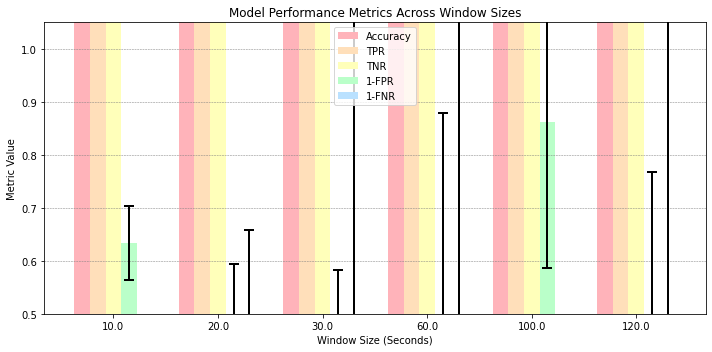

'\\section{Results}\n\\begin{table}[htbp]\n    \\centering\n    \\begin{tabular}{lrrrrr}\n        \\toprule\n        Window Size (Seconds) & Mean Accuracy & Mean TPR & Mean TNR & Mean FPR & Mean FNR \\\\\n        \\midrule\n        10.0 & 99.38 $\\pm$ 0.09 & 97.87 $\\pm$ 0.4 & 99.63 $\\pm$ 0.07 & 0.37 $\\pm$ 0.07 & 2.13 $\\pm$ 0.4 \\\\\n        20.0 & 99.40 $\\pm$ 0.06 & 99.08 $\\pm$ 0.58 & 99.46 $\\pm$ 0.14 & 0.54 $\\pm$ 0.14 & 0.92 $\\pm$ 0.58 \\\\\n        30.0 & 99.36 $\\pm$ 0.17 & 99.27 $\\pm$ 0.91 & 99.38 $\\pm$ 0.2 & 0.62 $\\pm$ 0.2 & 0.73 $\\pm$ 0.91 \\\\\n        60.0 & 99.42 $\\pm$ 0.41 & 99.19 $\\pm$ 0.99 & 99.45 $\\pm$ 0.43 & 0.55 $\\pm$ 0.43 & 0.81 $\\pm$ 0.99 \\\\\n        100.0 & 99.05 $\\pm$ 0.61 & 93.49 $\\pm$ 3.82 & 99.86 $\\pm$ 0.28 & 0.14 $\\pm$ 0.28 & 6.51 $\\pm$ 3.82 \\\\\n        120.0 & 98.75 $\\pm$ 1.05 & 95.87 $\\pm$ 5.08 & 99.03 $\\pm$ 0.73 & 0.97 $\\pm$ 0.73 & 4.13 $\\pm$ 5.08 \\\\\n        \\bottomrule\n    \\end{tabular}\n    \\caption{Table}\n    \\label{

In [9]:
# Metrics excluding FPR and FNR
metrics = ['Mean Accuracy', 'Mean TPR', 'Mean TNR', 'Mean FPR',  'Mean FNR']
std_cols = ['Std Accuracy', 'Std TPR', 'Std TNR', 'Std FPR', 'Std FNR']

# Assuming results_df is your DataFrame containing the data
plot_metrics_with_error_bars(results_df_abp, metrics, std_cols)

generate_latex_table(results_df_abp, metrics, std_cols)


In [11]:
# Directories
model_dir = "/home/sujay/PycharmProjects/line_labelling/models/cvp/"
dataset_dir = "/home/sujay/PycharmProjects/line_labelling/datasets/cvp/"

# Window sizes to iterate over
window_sizes = [1250, 2500, 3750, 7500, 12500, 15000]  # Example window sizes

# Initialize lists to store summary results
results_summary = []

for window_size in window_sizes:
    model_path = os.path.join(model_dir, f"random_window_{window_size}.h5")
    dataset_path = os.path.join(dataset_dir, f"random_window_{window_size}.pkl")
    
    model = load_model(model_path)
    data = load_dataset(dataset_path)  # Assuming data is loaded as X, Y
    _, _, _, _, x_test, y_test = data  # You would adjust this depending on your data structure
    
    mean_metrics, std_metrics = evaluate_model_in_folds(x_test, y_test, model, n_folds=5)
    
    # Append results including window size (converted to seconds), mean and std for each metric
    results_summary.append([window_size / 125] + list(mean_metrics) + list(std_metrics))

# Convert summary results to DataFrame
columns = ['Window Size (Seconds)', 'Mean Accuracy','Mean TPR', 'Mean TNR', "Mean FPR", "Mean FNR",
           'Std Accuracy', 'Std TPR', 'Std TNR', 'Std FPR', 'Std FNR']
results_df_cvp = pd.DataFrame(results_summary, columns=columns)

8/8 [==============================] - 0s 7ms/step


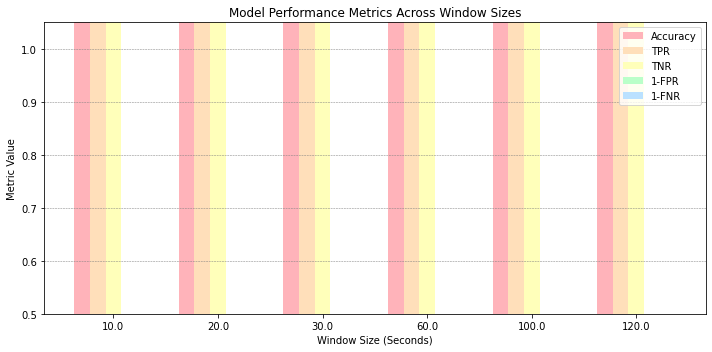

'\\section{Results}\n\\begin{table}[htbp]\n    \\centering\n    \\begin{tabular}{lrrrrr}\n        \\toprule\n        Window Size (Seconds) & Mean Accuracy & Mean TPR & Mean TNR & Mean FPR & Mean FNR \\\\\n        \\midrule\n        10.0 & 93.85 $\\pm$ 0.26 & 96.81 $\\pm$ 0.75 & 80.30 $\\pm$ 3.18 & 19.70 $\\pm$ 3.18 & 3.19 $\\pm$ 0.75 \\\\\n        20.0 & 80.62 $\\pm$ 0.9 & 74.07 $\\pm$ 1.44 & 97.39 $\\pm$ 1.58 & 2.61 $\\pm$ 1.58 & 25.93 $\\pm$ 1.44 \\\\\n        30.0 & 91.84 $\\pm$ 1 & 90.16 $\\pm$ 1.94 & 93.77 $\\pm$ 0.77 & 6.23 $\\pm$ 0.77 & 9.84 $\\pm$ 1.94 \\\\\n        60.0 & 96.50 $\\pm$ 0.66 & 97.36 $\\pm$ 1.61 & 96.07 $\\pm$ 1.09 & 3.93 $\\pm$ 1.09 & 2.64 $\\pm$ 1.61 \\\\\n        100.0 & 97.11 $\\pm$ 0.88 & 97.16 $\\pm$ 0.98 & 97.14 $\\pm$ 1.09 & 2.86 $\\pm$ 1.09 & 2.84 $\\pm$ 0.98 \\\\\n        120.0 & 97.20 $\\pm$ 0.95 & 95.06 $\\pm$ 2.01 & 97.92 $\\pm$ 0.79 & 2.08 $\\pm$ 0.79 & 4.94 $\\pm$ 2.01 \\\\\n        \\bottomrule\n    \\end{tabular}\n    \\caption{Table}\n    \\labe

In [12]:
# Metrics excluding FPR and FNR
metrics = ['Mean Accuracy', 'Mean TPR', 'Mean TNR', 'Mean FPR',  'Mean FNR']
std_cols = ['Std Accuracy', 'Std TPR', 'Std TNR', 'Std FPR', 'Std FNR']

# Assuming results_df is your DataFrame containing the data
plot_metrics_with_error_bars(results_df_cvp, metrics, std_cols)

generate_latex_table(results_df_cvp, metrics, std_cols)
